<a href="https://colab.research.google.com/github/yuriao/DataScienceProjects/blob/main/stock_prediction_lstm_proj2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Please Copy to your colab!!!**
# **Don't modify this notebook!!!**

# Stock Prediction RNN 

In this project, I perform a time series prediction using a Recurrent Neural Network regressor. For this example, I will predict Apple's stock price 7 days in advance.

The particular network architecture I will employ for my RNN is a  [Long Term Short Memory (LTSM)](https://en.wikipedia.org/wiki/Long_short-term_memory), which helps significantly avoid technical problems with optimization of RNNs.

# Pytorch LSTM Stock Predictor

This is a Pytorch version of the original Keras LSTM Stock Predictor provided by [Super DataScience](https://www.superdatascience.com/deep-learning/), and also available elsewhere in this repo as a notebook.

## Step 1: Loading the data

First let's load in our time series - a history of around 140 days of Apple's stock price. Then we need to perform a number of pre-processing steps to prepare it for use with an RNN model.  First off, it is good practice to normalize time series - by normalizing its range.  This helps us avoid serious numerical issues associated how common activation functions (like tanh) transform very large (positive or negative) numbers, as well as helping us to avoid related issues when computing derivatives.

Here we normalize the series to lie in the range [0,1] [using this scikit function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [ ]:
# download the data
!wget https://raw.githubusercontent.com/tonylaioffer/stock-prediction-lstm-using-keras/master/data/sandp500/all_stocks_5yr.csv

--2020-07-22 06:31:57--  https://raw.githubusercontent.com/tonylaioffer/stock-prediction-lstm-using-keras/master/data/sandp500/all_stocks_5yr.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29580549 (28M) [text/plain]
Saving to: ‘all_stocks_5yr.csv’

all_stocks_5yr.csv  100%[===================>]  28.21M   101MB/s    in 0.3s    

2020-07-22 06:31:59 (101 MB/s) - ‘all_stocks_5yr.csv’ saved [29580549/29580549]



In [ ]:
!ls .

all_stocks_5yr.csv  sample_data


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Importing the training set
dataset = data = pd.read_csv('./all_stocks_5yr.csv')
dataset_cl = dataset[dataset['Name']=='SWKS'].close.values

# dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
# training_set = dataset_train.iloc[:, 1:2].values

In [ ]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))

# scale the data
dataset_cl = dataset_cl.reshape(dataset_cl.shape[0], 1)
dataset_cl = sc.fit_transform(dataset_cl)

## Step 2:  Cutting our time series into sequences

Remember, our time series is a sequence of numbers that we can represent in general mathematically as 

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="https://github.com/tonylaioffer/stock-prediction-lstm-using-keras/raw/master/images/timeseries_windowing_training.gif" width=600 height=288/>

For example - using a window of size T = 5 (as illustrated in the gif above) we produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice here that each input is a sequence (or vector) of length 4 (and in general has length equal to the window size T) while each corresponding output is a scalar value.  Notice also how given a time series of length P and window size T = 5 as shown above, we created P - 5  input/output pairs.  More generally, for a window size T we create P - T such pairs.

Now let's window the input time series as described above!  

In [ ]:
#Create a function to process the data into 7 day look back slices
def processData(data, lb):
    X, Y = [], []
    for i in range(len(data) - lb - 1):
        X.append(data[i: (i + lb), 0])
        Y.append(data[(i + lb), 0])
    return np.array(X), np.array(Y)
X, y = processData(dataset_cl, 7)


## Step 3: Split training and testing sets

In order to perform proper testing on our dataset we will lop off the last 1/3 of it for validation (or testing).  

Note how here we are **not** splitting the dataset *randomly* as one typically would do when validating a regression model.  This is because our input/output pairs *are related temporally*.   We don't want to validate our model by training on a random subset of the series and then testing on another random subset, as this simulates the scenario that we receive new points *within the timeframe of our training set*.  

We want to train on one solid chunk of the series (in our case, the first full 2/3 of it), and validate on a later chunk (the last 1/3) as this simulates how we would predict *future* values of a time series.

In [ ]:
X_train, X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train, y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

1000
251
1000
251


In [ ]:
# Reshaping
# X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

## Step 4:  Build and run an RNN regression model

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN.  We use Keras to quickly build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module with 5 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used

In [ ]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size, dropout=0.1, bidirectional=True):
        super(RNN, self).__init__()
        self.num_directions = bidirectional+1
        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers,
            dropout=dropout,
            bidirectional=bidirectional
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, self.num_directions, hidden_size)
        outs = self.out(r_out)
        
        return outs, hidden_state

In [ ]:
# Globals

INPUT_SIZE = 7
HIDDEN_SIZE = 64
NUM_LAYERS = 3
OUTPUT_SIZE = 1
BATCH_SIZE = 128
# Hyper parameters

learning_rate = 0.001
num_epochs = 300

rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE,bidirectional=False)
rnn.cuda()

optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

hidden_state = None

In [ ]:
rnn

RNN(
  (rnn): LSTM(7, 64, num_layers=3, dropout=0.1)
  (out): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
"""
class StockDataset(Dataset):
    
    def __init__(self, X_dataset, Y_dataset):
        
        self.X_dataset = torch.from_numpy(X_dataset)
        self.Y_dataset = torch.from_numpy(Y_dataset)
        
    def __len__(self):
        return np.shape(self.Y_dataset)[0]

    def __getitem__(self, idx):
        
        sample = {'Sequence': self.X_dataset[:,idx,:], "Target": self.Y_dataset[idx]}
      

        return sample
"""

'\nclass StockDataset(Dataset):\n    \n    def __init__(self, X_dataset, Y_dataset):\n        \n        self.X_dataset = torch.from_numpy(X_dataset)\n        self.Y_dataset = torch.from_numpy(Y_dataset)\n        \n    def __len__(self):\n        return np.shape(self.Y_dataset)[0]\n\n    def __getitem__(self, idx):\n        \n        sample = {\'Sequence\': self.X_dataset[:,idx,:], "Target": self.Y_dataset[idx]}\n      \n\n        return sample\n'

In [ ]:
# Train_ds=StockDataset(X_train, y_train)

In [ ]:
history = []
X_test_cuda = torch.tensor(X_test).float().cuda()
y_test_cuda = torch.tensor(y_test).float().cuda()

# we use all the data in one batch
inputs_cuda = torch.tensor(X_train).float().cuda()
labels_cuda = torch.tensor(y_train).float().cuda()

for epoch in range(num_epochs):
    rnn.train()
    output, _ = rnn(inputs_cuda, hidden_state) 
    # print(output.size())

    loss = criterion(output[:,0,:].view(-1), labels_cuda)
    optimiser.zero_grad()
    loss.backward()                     # back propagation
    optimiser.step()                    # update the parameters
    
    if epoch % 20 == 0:
        rnn.eval()
        test_output, _ = rnn(X_test_cuda, hidden_state)
        test_loss = criterion(test_output.view(-1), y_test_cuda)
        print('epoch {}, loss {}, eval loss {}'.format(epoch, loss.item(), test_loss.item()))
    else:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
    history.append(loss.item())

epoch 0, loss 0.3530898988246918, eval loss 0.8763517737388611
epoch 1, loss 0.32034310698509216
epoch 2, loss 0.288117378950119
epoch 3, loss 0.2564181685447693
epoch 4, loss 0.22358006238937378
epoch 5, loss 0.18949227035045624
epoch 6, loss 0.1535922884941101
epoch 7, loss 0.117123544216156
epoch 8, loss 0.07935792952775955
epoch 9, loss 0.0465887188911438
epoch 10, loss 0.027329126372933388
epoch 11, loss 0.04260720685124397
epoch 12, loss 0.07097126543521881
epoch 13, loss 0.06731559336185455
epoch 14, loss 0.04966617003083229
epoch 15, loss 0.03427502140402794
epoch 16, loss 0.026757366955280304
epoch 17, loss 0.025995370000600815
epoch 18, loss 0.029208505526185036
epoch 19, loss 0.03239896148443222
epoch 20, loss 0.03533990681171417, eval loss 0.1372881531715393
epoch 21, loss 0.03535500913858414
epoch 22, loss 0.034019578248262405
epoch 23, loss 0.0316493958234787
epoch 24, loss 0.026990870013833046
epoch 25, loss 0.021643180400133133
epoch 26, loss 0.01678553596138954
epoch 2

In [ ]:
rnn.out.weight 

Parameter containing:
tensor([[-0.0569,  0.0199, -0.1157,  0.0948,  0.0923, -0.0310, -0.0259,  0.1303,
         -0.0255, -0.1197,  0.0506,  0.1093, -0.0998, -0.1169, -0.0220, -0.0446,
         -0.1124,  0.0905,  0.0569,  0.1127,  0.1179, -0.0363,  0.1057,  0.0409,
          0.0329, -0.0431,  0.0569, -0.0079, -0.0850, -0.0475, -0.0394,  0.0270,
          0.1004, -0.0640,  0.0824,  0.0356,  0.0137,  0.0867, -0.0647,  0.0924,
         -0.1268, -0.1000, -0.1311,  0.1142,  0.1277,  0.1247,  0.0371, -0.0708,
          0.0935,  0.0926, -0.1027, -0.1242,  0.1051, -0.0811,  0.0005, -0.0488,
         -0.0978,  0.1169,  0.0237, -0.0652,  0.0851,  0.0777,  0.0361, -0.0682]],
       device='cuda:0', requires_grad=True)

In [ ]:
for param in rnn.parameters():
    print(param.data)

tensor([[ 0.0008, -0.0166, -0.0161,  ..., -0.0940, -0.0778,  0.0439],
        [ 0.1008, -0.1000, -0.0374,  ...,  0.0843, -0.0743, -0.0801],
        [-0.0897, -0.1103, -0.0152,  ...,  0.0687, -0.0560,  0.0825],
        ...,
        [ 0.0714,  0.0714,  0.0290,  ...,  0.0324,  0.0912, -0.0088],
        [-0.0440,  0.1278,  0.1122,  ...,  0.0030,  0.0353,  0.0903],
        [-0.0023,  0.0872, -0.1218,  ..., -0.0951,  0.0614, -0.0449]],
       device='cuda:0')
tensor([[ 0.0470,  0.0732, -0.0916,  ...,  0.0973, -0.0555,  0.1460],
        [ 0.0786, -0.0077,  0.1159,  ...,  0.0578,  0.0108, -0.0461],
        [-0.0508, -0.0728, -0.0910,  ..., -0.0231, -0.0386, -0.0641],
        ...,
        [-0.0158, -0.0406, -0.0750,  ..., -0.0109, -0.0746,  0.0076],
        [ 0.0512,  0.0423, -0.0353,  ...,  0.0286,  0.0125, -0.0981],
        [ 0.0261,  0.0147, -0.0280,  ...,  0.0831, -0.0042,  0.0130]],
       device='cuda:0')
tensor([ 0.1118, -0.0722,  0.0652, -0.0428, -0.0745,  0.1512,  0.0508,  0.1087,
    

## Step 5: Checking model performance

With our model fit we can now make predictions on both our training and testing sets.

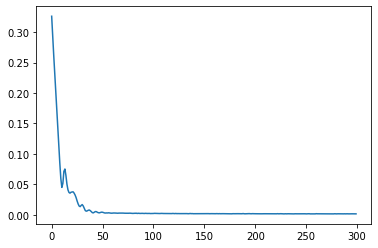

In [ ]:
plt.plot(history)
# dplt.plot(history.history['val_loss'])

In [ ]:
X_test[0]

array([[0.75733001, 0.74433354, 0.74433354, 0.73778332, 0.74246205,
        0.74069453, 0.74474943]])

In [ ]:
# X_train_X_test = np.concatenate((X_train, X_test),axis=0)
# hidden_state = None
rnn.eval()
# test_inputs = torch.tensor(X_test).float().cuda()
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

In [ ]:
test_predict_cpu.shape

(251, 1, 1)

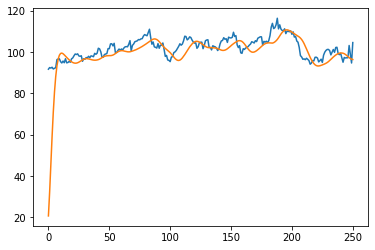

In [ ]:
plt.plot(sc.inverse_transform(y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(test_predict_cpu.reshape(-1,1)))

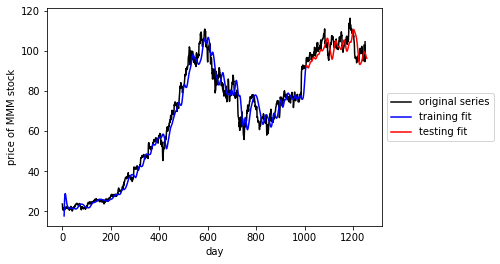

In [ ]:
# plot original data
plt.plot(sc.inverse_transform(y.reshape(-1,1)), color='k')

# train_inputs = torch.tensor(X_train).float().cuda()
train_pred, hidden_state = rnn(inputs_cuda, None)
train_pred_cpu = train_pred.cpu().detach().numpy()

# use hidden state from previous training data
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

# plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
split_pt = int(X.shape[0] * 0.80) + 7 # window_size
plt.plot(np.arange(7, split_pt, 1), sc.inverse_transform(train_pred_cpu.reshape(-1,1)), color='b')
plt.plot(np.arange(split_pt, split_pt + len(test_predict_cpu), 1), sc.inverse_transform(test_predict_cpu.reshape(-1,1)), color='r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('price of MMM stock')
plt.legend(['original series','training fit','testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
